# This notebook is used to study the first point drop of the TRC correlation data

In [124]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from ellipse import LsqEllipse
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from skimage import io
import matplotlib.pyplot as plt
import math
import pickle
import statistics
from statistics import mean
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
import pickle

In [125]:
import sys
import sys
sys.path.append('../')
from inference.read_in_data import *
from inference.correlation_heatmap import *
from inference.calculating_tau import *
from inference.dedrift import *

In [162]:
def compute_g2t_wo_kernel(px,laglist_g2t,normalize=True):
    intensity=[]
    for t in range(0,img.shape[0],1):
        intensity.append(img[t][px[0],px[1]])
        
    g2t=np.zeros(len(laglist_g2t))
    for lag in laglist_g2t:
        numerator=[]
        denumerator1=[]
        denumerator2=[]
        max_t_range=len(intensity)-lag
        for t in range(0,max_t_range,1):
            numerator.append(int(intensity[t])*int(intensity[t+lag]))
            denumerator1.append(intensity[t])
            denumerator2.append(intensity[t+lag])
        g2t[lag]=(np.array(numerator).mean()/np.array(denumerator1).mean()/np.array(denumerator2).mean())-1
        #g2t[lag]=g2t[lag]/g2t[0]
    if normalize:
        first=g2t[0]
        for lag in laglist_g2t:
            g2t[lag]=g2t[lag]/first
    return g2t

# 20% HS gel

## 10x Objective 1 avg

In [163]:
video_time_length=60 #s
imgname='10x_600gritgroundglass_405laser_0p52au_1avg'
foldername='/Volumes/WENYUN WANG/20221017/'

In [164]:
# read the image stack
img = io.imread(foldername+imgname+'.tif')
frame_number=img.shape[0]
img_height=img.shape[1]
img_width=img.shape[2]
framespeed=video_time_length/frame_number

In [165]:
print(framespeed)

0.6060606060606061


In [166]:
laglist_g2t=range(0,3,1)
averaged_g2t=[]
for y in range(1,19,1):
    for x in range(10,40,1):
        px=[y,x]
        g2t=compute_g2t_wo_kernel(px,laglist_g2t)
        averaged_g2t.append(g2t)

In [167]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg_temperal.p',"wb"))

In [168]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg_temperal.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]

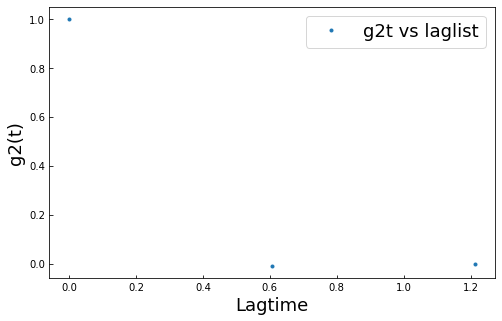

In [169]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[:],average_g2t[:],'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')

In [170]:
print(average_g2t)

[ 1.         -0.00939235 -0.00277067]


## 10x Objective 8 avg

In [171]:
video_time_length=60 #s
imgname='10x_HSgel_405laser_0p52au_1000umheight_643gain17plaser_1min_8avg'
foldername='/Volumes/WENYUN WANG/20221017/'

# read the image stack
img = io.imread(foldername+imgname+'.tif')
frame_number=img.shape[0]
img_height=img.shape[1]
img_width=img.shape[2]
framespeed=video_time_length/frame_number

laglist_g2t=range(0,3,1)
averaged_g2t=[]
for y in range(1,19,1):
    for x in range(10,40,1):
        px=[y,x]
        g2t=compute_g2t_wo_kernel(px,laglist_g2t)
        averaged_g2t.append(g2t)

In [172]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg_temperal_2d.p',"wb"))

In [173]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg_temperal_2d.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]

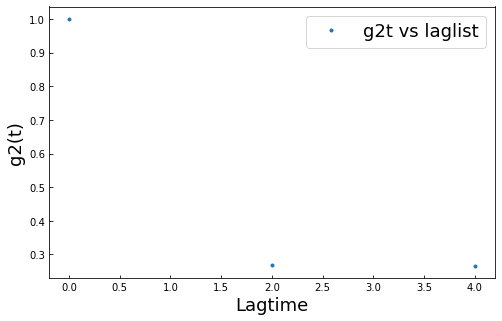

In [174]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[0:100],average_g2t[0:100],'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')

# TRC

In [ ]:
# for one pixel
def TRC(pixel,kernel_size_y, kernel_size_x, t_interest, tau_interest):
    correlation_2d=np.zeros((len(t_interest),len(tau_interest)))
    total_tlength=len(t_interest)+len(tau_interest)
    # get intensity data
    intensity=np.zeros((total_tlength, 2*kernel_size_y, 2*kernel_size_x))
    y=pixel[0]
    x=pixel[1]
    for yindex,i in enumerate(range(y-kernel_size_y, y+kernel_size_y)):
        for xindex, j in enumerate(range(x-kernel_size_x, x+kernel_size_x)):
            for t in range(total_tlength):
                intensity[t,yindex,xindex]=img[t,i,j]
    value=(2*kernel_size_x)*(2*kernel_size_y)
    intensity=np.reshape(intensity,(total_tlength, value))
    print(intensity.shape)
    # compute correlation
    for t in t_interest:
        for tau in tau_interest:
            numerator=[]
            denum1=[]
            denum2=[]
            for i in range(intensity.shape[1]):
                It=intensity[t,i]
                Ittau=intensity[t+tau,i]
                numerator.append(It*Ittau)
                denum1.append(It)
                denum2.append(Ittau)
            correlation_2d[t,tau]=np.array(numerator).mean()/(np.array(denum1).mean()*np.array(denum2).mean())-1
            correlation_2d[t,tau]=correlation_2d[t,tau]/correlation_2d[t,0]
    
    return correlation_2d

In [ ]:
laglist_g2t=range(0,50,1)
t_range=range(0,500,1)
TRC_corr=TRC([10,225],10,225,t_range,laglist_g2t)

In [ ]:
plt.plot(TRC_corr[10,:],'.')

In [ ]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(TRC_corr[10,:]),lagtime_g2t,1,13, True)

In [ ]:
reconstruct(lagtime_g2t[0:50],plateau,np.array(TRC_corr[10,:]),a,b)
plt.yscale("log")

In [ ]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

# Average over spatial and temporal

In [ ]:
# for one pixel
def spatial_temporal(pixel,kernel_size_y, kernel_size_x, t_interest, tau_interest):
    correlation=np.zeros(len(tau_interest))
    
    total_tlength=len(t_interest)+len(tau_interest)
    # get intensity data
    intensity=np.zeros((total_tlength, 2*kernel_size_y, 2*kernel_size_x))
    y=pixel[0]
    x=pixel[1]
    for yindex,i in enumerate(range(y-kernel_size_y, y+kernel_size_y)):
        for xindex, j in enumerate(range(x-kernel_size_x, x+kernel_size_x)):
            for t in range(total_tlength):
                intensity[t,yindex,xindex]=img[t,i,j]
    value=(2*kernel_size_x)*(2*kernel_size_y)
    intensity=np.reshape(intensity,(total_tlength, value))
    print(intensity.shape)
    # compute correlation

    for tau in tau_interest:
        numerator=[]
        denum1=[]
        denum2=[]
        for t in t_interest:
            for i in range(intensity.shape[1]):
                It=intensity[t,i]
                Ittau=intensity[t+tau,i]
                numerator.append(It*Ittau)
                denum1.append(It)
                denum2.append(Ittau)
        correlation[tau]=np.array(numerator).mean()/(np.array(denum1).mean()*np.array(denum2).mean())-1
        correlation[tau]=correlation[tau]/correlation[0]

    return correlation

In [ ]:
laglist_g2t=range(0,50,1)
t_range=range(0,500,1)
spatemp_corr=spatial_temporal([10,225],10,225,t_range,laglist_g2t)

In [ ]:
plt.plot(spatemp_corr[:],'.')

In [ ]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(spatemp_corr[:]),lagtime_g2t,1,4, True)

In [ ]:
reconstruct(lagtime_g2t[0:50],plateau,np.array(spatemp_corr[:]),a,b)
plt.yscale("log")

In [ ]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

# line scanning

In [ ]:
def compute_g2t_wo_kernel_line(img,x,laglist_g2t):
    intensity=[]
    for t in range(0,img.shape[1],1):
        intensity.append(img[0,t,0,0,0,x,0])
    plt.plot(intensity[0:50],'-')
        
    g2t=[]
    for lag in laglist_g2t:
        numerator_sum=0
        denumerator_sum_1=0
        denumerator_sum_2=0
        max_t_range=len(intensity)-lag
        for t in range(0,max_t_range,1):
            numerator_sum=numerator_sum+int(intensity[t])*int(intensity[t+lag])
            denumerator_sum_1=denumerator_sum_1+int(intensity[t])
            denumerator_sum_2=denumerator_sum_2+int(intensity[t+lag])
        numerator=numerator_sum/max_t_range
        denumerator_1=denumerator_sum_1/max_t_range
        denumerator_2=denumerator_sum_2/max_t_range
        g2t.append((numerator/denumerator_1/denumerator_2)-1)
    return g2t

In [ ]:
video_time_length=10
imgname='0p05ps_beads_inglycerol_405laser_10xobj_0p52au_10s_2avg_linescan_bidirc'
foldername='/Volumes/WENYUN WANG/20221129/0p05_PSbeads_in_glycerol/'

In [ ]:
import czifile
from skimage import io

img = czifile.imread(foldername+imgname+".czi")

In [ ]:
img.shape

In [ ]:
img[0,3,0,0,0,9,0]

In [ ]:
# read the image stack
frame_number=img.shape[1]
img_width=img.shape[5]
framespeed=video_time_length/frame_number

In [ ]:
img.shape

In [ ]:
laglist_g2t=range(0,1000,1)
averaged_g2t=[]
for x in range(1,150,1):
    g2t=compute_g2t_wo_kernel_line(img,x,laglist_g2t)
    averaged_g2t.append(g2t)

In [ ]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg.p',"wb"))

In [ ]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[0:3000],average_g2t[0:3000],'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')

In [ ]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(average_g2t),lagtime_g2t,1,10, True)

In [ ]:
reconstruct(lagtime_g2t[0:60],plateau,np.array(average_g2t[0:60]),a,b)
#plt.ylim(0,0.1)
#plt.xlim(0,lagtime_g2t[20])
plt.yscale("log")

In [ ]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)